In [2]:
import numpy as np
import keras
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.utils.layer_utils import count_params
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
mobile = keras.applications.mobilenet.MobileNet()

AttributeError: module 'keras.applications' has no attribute 'mobilenet'

In [11]:
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

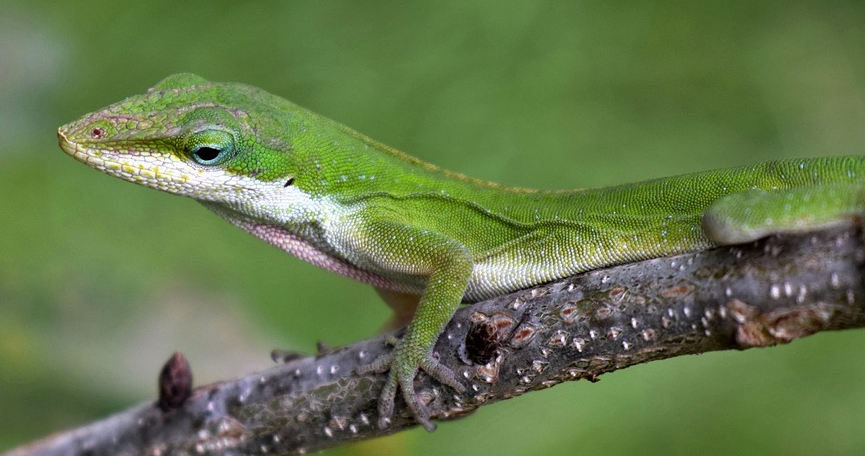

In [13]:
from IPython.display import Image
Image(filename='data/MobileNet-samples/1.PNG', width=300,height=200) 

In [14]:
preprocessed_image = prepare_image('1.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

AttributeError: module 'keras.applications' has no attribute 'mobilenet'

In [15]:
assert results[0][0][1] == 'American_chameleon'

NameError: name 'results' is not defined

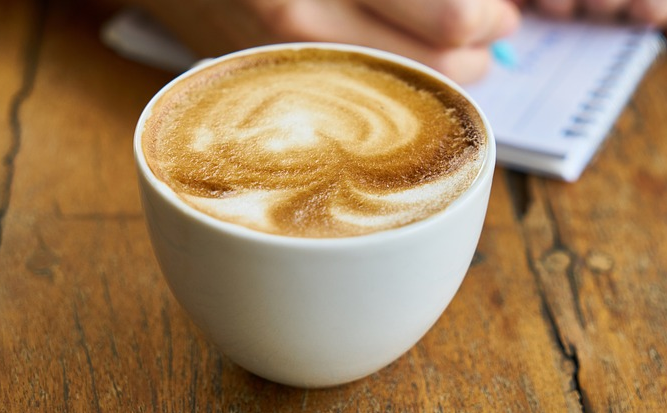

In [16]:
Image(filename='data/MobileNet-samples/2.PNG', width=300,height=200) 

In [17]:
preprocessed_image = prepare_image('2.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

AttributeError: module 'keras.applications' has no attribute 'mobilenet'

In [ ]:
assert results[0][0][1] == 'espresso'

In [ ]:
Image(filename='data/MobileNet-samples/3.PNG', width=300,height=200) 

In [ ]:
preprocessed_image = prepare_image('3.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

In [ ]:
train_path = 'data/cats-and-dogs/train'
valid_path = 'data/cats-and-dogs/valid'
test_path = 'data/cats-and-dogs/test'

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

In [ ]:
assert train_batches.n == 40
assert valid_batches.n == 16
assert test_batches.n == 10
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [ ]:
mobile = keras.applications.mobilenet.MobileNet()

In [ ]:
mobile.summary()

In [ ]:
assert count_params(mobile.non_trainable_weights) == 21888
assert count_params(mobile.trainable_weights) == 4231976

In [ ]:
x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model.summary()

In [ ]:
assert count_params(model.non_trainable_weights) == 21888
assert count_params(model.trainable_weights) == 3209026

In [ ]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [ ]:
model.summary()

In [ ]:
assert count_params(model.non_trainable_weights) == 2178240
assert count_params(model.trainable_weights) == 1052674

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(generator=train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=2, epochs=30, verbose=2)

In [ ]:
assert model.history.history.get('accuracy')[-1] > 0.95

In [ ]:
test_labels = test_batches.classes

In [ ]:
test_batches.class_indices

In [ ]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

In [ ]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
assert np.sum(test_labels == predictions.argmax(axis=1)) > 8